# Python: Impact of 401(k) on Financial Wealth (Quantile Effects)

In this real-data example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the effect of 401(k) eligibility and participation on accumulated assets. The 401(k) data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060), see [Kallus et al. (2019)](https://arxiv.org/abs/1912.12945) for quantile effects.

**Remark:**
This notebook focuses on the evaluation of the treatment effect at different quantiles. For a basic introduction to the [DoubleML](https://docs.doubleml.org/stable/index.html) package and a detailed example of the average treatment effect estimation for the 401(k) data set, we refer to the notebook [Python: Impact of 401(k) on Financial Wealth](https://docs.doubleml.org/stable/examples/py_double_ml_pension.html). The Data sections of both notebooks coincide.

401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

## Data

The preprocessed data can be fetched by calling [fetch_401K()](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.fetch_401K.html#doubleml.datasets.fetch_401K). Note that an internet connection is required for loading the data.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing
from doubleml.datasets import fetch_401K

from sklearn.base import clone

from lightgbm import LGBMClassifier, LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
colors = sns.color_palette()

In [3]:
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

In [4]:
data = fetch_401K(return_type='DataFrame')

In [5]:
data.describe()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
count,9.915000e+03,9.915000e+03,9.915000e+03,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,1.392864e+04,1.805153e+04,6.381685e+04,41.060212,37200.621094,2.865860,13.206253,0.271004,0.604841,0.380837,0.371357,0.261624,0.242158,0.635199
std,5.490488e+04,6.352250e+04,1.115297e+05,10.344505,24774.289062,1.538937,2.810382,0.444500,0.488909,0.485617,0.483192,0.439541,0.428411,0.481399
min,0.000000e+00,-5.023020e+05,-5.023020e+05,25.000000,-2652.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+02,-5.000000e+02,3.291500e+03,32.000000,19413.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.635000e+03,1.499000e+03,2.510000e+04,40.000000,31476.000000,3.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.765500e+03,1.652450e+04,8.148750e+04,48.000000,48583.500000,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.430298e+06,1.536798e+06,2.029910e+06,64.000000,242124.000000,13.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

At first consider eligibility as the treatment and define the following data.

In [6]:
# Set up basic model: Specify variables for data-backend
features_base = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown']


# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='net_tfa',
                                 d_cols='e401',
                                 x_cols=features_base)

## Estimating Potential Quantiles and Quantile Treatment Effects

We will use the [DoubleML](https://docs.doubleml.org/stable/index.html) package to estimate quantile treatment effects of 401(k) eligibility, i.e. `e401`.
As it is more interesting to take a look at a range of quantiles instead of a single one, we will first define a discretisized grid of quanitles `tau_vec`, which will range from the 10%-quantile to the 90%-quantile.
Further, we need a machine learning algorithm to estimate the nuisance elements of our model. In this example, we will use a basic `LGBMClassifier`.

In [7]:
tau_vec = np.arange(0.1,0.95,0.05)
n_folds = 5

# Learners
class_learner = LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=10)
reg_learner = LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=10)

Next, we will apply create an `DoubleMLPQ` object for each quantile to fit a quantile model. Here, we have to specifiy, whether we would like to estimate a potential quantile for the treatment group `treatment=1` or control `treatment=0`. Further basic options are trimming and normalization of the propensity scores (`trimming_rule="truncate"`, `trimming_threshold=0.01` and `normalize_ipw=True`). 

In [8]:
PQ_0 = np.full((len(tau_vec)), np.nan)
PQ_1 = np.full((len(tau_vec)), np.nan)

ci_PQ_0 = np.full((len(tau_vec),2), np.nan)
ci_PQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')
    dml_PQ_0 = dml.DoubleMLPQ(data_dml_base, 
                              ml_g=clone(class_learner),
                              ml_m=clone(class_learner),
                              score="PQ",
                              treatment=0,
                              quantile=tau,
                              n_folds=n_folds,
                              normalize_ipw=True,
                              trimming_rule="truncate",
                              trimming_threshold=1e-2)
    dml_PQ_1 = dml.DoubleMLPQ(data_dml_base,
                              ml_g=clone(class_learner),
                              ml_m=clone(class_learner),
                              score="PQ",
                              treatment=1,
                              quantile=tau,
                              n_folds=n_folds,
                              normalize_ipw=True,
                              trimming_rule="truncate",
                              trimming_threshold=1e-2)

    dml_PQ_0.fit()
    dml_PQ_1.fit()

    PQ_0[idx_tau] = dml_PQ_0.coef
    PQ_1[idx_tau] = dml_PQ_1.coef

    ci_PQ_0[idx_tau, :] = dml_PQ_0.confint(level=0.95).to_numpy()
    ci_PQ_1[idx_tau, :] = dml_PQ_1.confint(level=0.95).to_numpy()

Quantile: 0.1


Quantile: 0.15000000000000002


Quantile: 0.20000000000000004


Quantile: 0.25000000000000006


Quantile: 0.30000000000000004


Quantile: 0.3500000000000001


Quantile: 0.40000000000000013


Quantile: 0.45000000000000007


Quantile: 0.5000000000000001


Quantile: 0.5500000000000002


Quantile: 0.6000000000000002


Quantile: 0.6500000000000001


Quantile: 0.7000000000000002


Quantile: 0.7500000000000002


Quantile: 0.8000000000000002


Quantile: 0.8500000000000002


Quantile: 0.9000000000000002


Additionally, each `DoubleMLPQ` object has a (hopefully) helpful summary, which indicates also the evaluation of the nuisance elements with cross-validated estimation. See e.g. `dml_PQ_1'

In [9]:
print(dml_PQ_1)

================== DoubleMLPQ Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: PQ
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: LGBMClassifier(learning_rate=0.05, n_estimators=300, num_leaves=10)
Learner ml_m: LGBMClassifier(learning_rate=0.05, n_estimators=300, num_leaves=10)
Out-of-sample Performance:
Learner ml_g RMSE: [[0.31320292]]
Learner ml_m RMSE: [[0.44465939]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
         coef      std err          t          P>|t|         2.5 %   
e401  63779.0  1921.969121 

Finally, let us take a look at the estimated potential quantiles

In [10]:
data_pq = {"Quantile": tau_vec,
           "DML Y(0)": PQ_0, "DML Y(1)": PQ_1,
           "DML Y(0) lower": ci_PQ_0[:, 0], "DML Y(0) upper": ci_PQ_0[:, 1],
           "DML Y(1) lower": ci_PQ_1[:, 0], "DML Y(1) upper": ci_PQ_1[:, 1]}
df_pq = pd.DataFrame(data_pq)
print(df_pq)

    Quantile      DML Y(0)      DML Y(1)  DML Y(0) lower  DML Y(0) upper   
0       0.10 -5.350000e+03 -3.780000e+03    -5739.187994    -4960.812006  \
1       0.15 -3.200000e+03 -1.801000e+03    -3423.266079    -2976.733921   
2       0.20 -1.900000e+03 -6.010000e+02    -2059.751378    -1740.248622   
3       0.25 -9.960000e+02 -1.246471e-12    -1136.265944     -855.734056   
4       0.30 -3.000000e+02  2.000000e+02     -435.897575     -164.102425   
5       0.35 -1.607589e-13  1.100000e+03     -140.813276      140.813276   
6       0.40  7.529635e-13  2.006000e+03     -141.854458      141.854458   
7       0.45  1.000000e+02  4.000000e+03      -47.459071      247.459071   
8       0.50  5.000000e+02  4.900000e+03      353.729865      646.270135   
9       0.55  1.200000e+03  7.000000e+03     1038.864842     1361.135158   
10      0.60  2.300000e+03  9.298000e+03     2085.596515     2514.403485   
11      0.65  4.000000e+03  1.349900e+04     3622.592008     4377.407992   
12      0.70

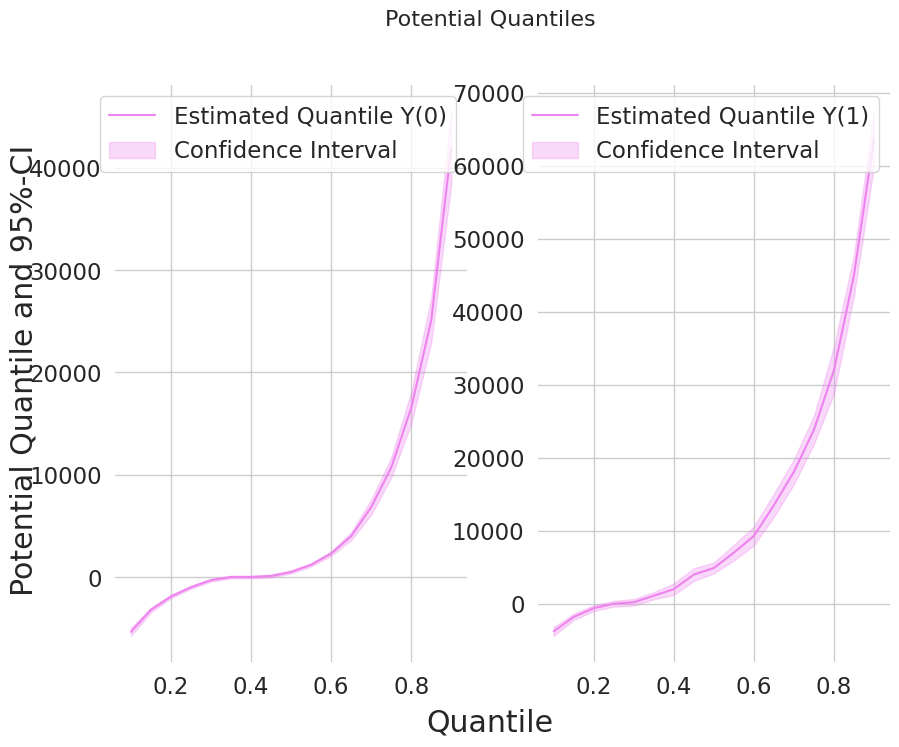

In [11]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)
ax1.grid(visible=True); ax2.grid(visible=True)

ax1.plot(df_pq['Quantile'],df_pq['DML Y(0)'], color='violet', label='Estimated Quantile Y(0)')
ax1.fill_between(df_pq['Quantile'], df_pq['DML Y(0) lower'], df_pq['DML Y(0) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax1.legend()

ax2.plot(df_pq['Quantile'],df_pq['DML Y(1)'], color='violet', label='Estimated Quantile Y(1)')
ax2.fill_between(df_pq['Quantile'], df_pq['DML Y(1) lower'], df_pq['DML Y(1) upper'], color='violet', alpha=.3, label='Confidence Interval')
ax2.legend()


fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
_ = fig.supylabel('Potential Quantile and 95%-CI')

As we are interested in the QTE, we can use the `DoubleMLQTE` object, which internally fits two `DoubleMLPQ` objects for the treatment and control group. The main advantage is to apply this to a list of quantiles and construct uniformly valid confidence intervals for the range of treatment effects.

In [12]:
n_cores = multiprocessing.cpu_count()
cores_used = np.min([5, n_cores - 1])
print(f"Number of Cores used: {cores_used}")

np.random.seed(42)
dml_QTE = dml.DoubleMLQTE(data_dml_base,
                           ml_g=clone(class_learner),
                           ml_m=clone(class_learner),
                           quantiles=tau_vec,
                           score='PQ',
                           n_folds=n_folds,
                           normalize_ipw=True,
                           trimming_rule="truncate",
                           trimming_threshold=1e-2)
dml_QTE.fit(n_jobs_models=cores_used)
print(dml_QTE)

Number of Cores used: 1


================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
         coef      std err          t         P>|t|         2.5 %   
0.10   1210.0   486.438569   2.487467  1.286563e-02    256.597923  \
0.15   1230.0   263.748513   4.663533  3.108257e-06    713.062414   
0.20   1211.0   251.948868   4.806531  1.535718e-06    717.189293   
0.25   1000.0   244.841847   4.084269  4.421576e-05    520.118799   
0.30    622.0   255.252133   2.436806  1.481761e-02    121.715013   
0.35   1031.0   274.813682   3.751633  1.756867e-04    492.375081   
0.40   2006.0   320.163566   6.265547  3.715180e-10   1378.490941   
0.45   3329.0   427.336461   7.790115  6.694845e-15   2491.435927   
0.50   4601.0   448.109454  10.267581  9.864741e-25   3722.721609   
0.55   6000.0   588.816752  10.189927  2.199282e-24   4845.940373   
0.60   7040.0   605.739720  11.622153  3.180176e-31   5852.771965   
0.65   9223.0   804.541821  11.463668  2.008266e-30   7646

For uniformly valid confidence intervals, we still need to apply a bootstrap first. 
Let's take a quick look at the QTEs combinded with a confidence interval.

In [13]:
dml_QTE.bootstrap(n_rep_boot=2000)
ci_QTE = dml_QTE.confint(level=0.95, joint=True)

data_qte = {"Quantile": tau_vec, "DML QTE": dml_QTE.coef,
            "DML QTE lower": ci_QTE["2.5 %"], "DML QTE upper": ci_QTE["97.5 %"]}
df_qte = pd.DataFrame(data_qte)
print(df_qte)

      Quantile  DML QTE  DML QTE lower  DML QTE upper
0.10      0.10   1210.0    -163.857765    2583.857765
0.15      0.15   1230.0     485.090025    1974.909975
0.20      0.20   1211.0     499.415988    1922.584012
0.25      0.25   1000.0     308.488485    1691.511515
0.30      0.30    622.0     -98.913485    1342.913485
0.35      0.35   1031.0     254.838457    1807.161543
0.40      0.40   2006.0    1101.755910    2910.244090
0.45      0.45   3329.0    2122.065451    4535.934549
0.50      0.50   4601.0    3335.395889    5866.604111
0.55      0.55   6000.0    4336.993575    7663.006425
0.60      0.60   7040.0    5329.197711    8750.802289
0.65      0.65   9223.0    6950.717130   11495.282870
0.70      0.70  10928.0    8499.917066   13356.082934
0.75      0.75  12410.0    9534.518782   15285.481218
0.80      0.80  16590.0   12101.036945   21078.963055
0.85      0.85  19382.0   14798.973331   23965.026669
0.90      0.90  21550.0   15113.220088   27986.779912


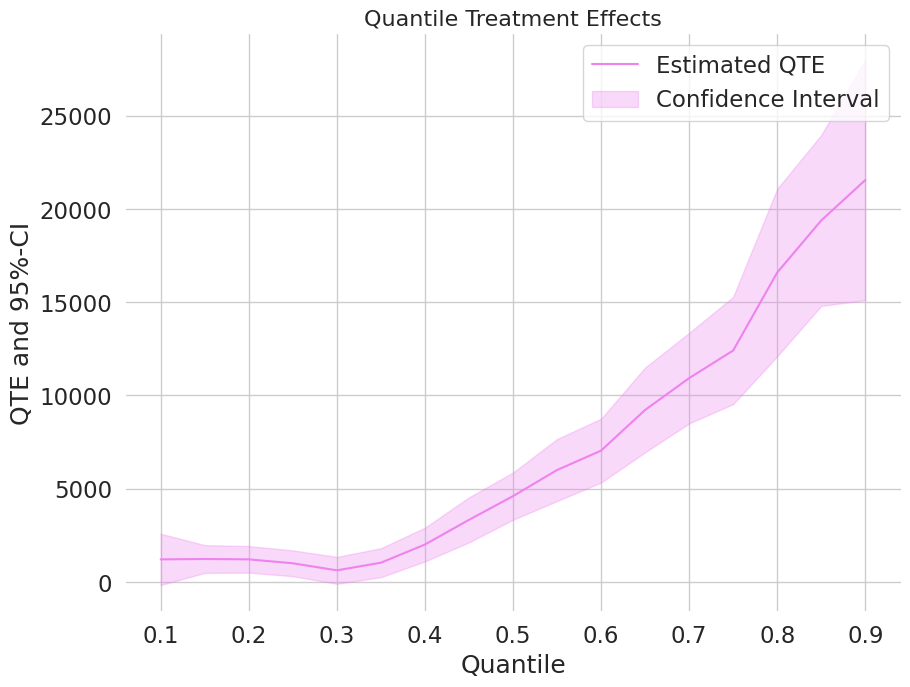

In [14]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid(visible=True)


ax.plot(df_qte['Quantile'],df_qte['DML QTE'], color='violet', label='Estimated QTE')
ax.fill_between(df_qte['Quantile'], df_qte['DML QTE lower'], df_qte['DML QTE upper'], color='violet', alpha=.3, label='Confidence Interval')


plt.legend()
plt.title('Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('QTE and 95%-CI')

## Estimating the treatment effect on the Conditional Value a Risk (CVaR)

Similar to the evaluation of the estimation of quantile treatment effects (QTEs), we can estimate the conditional value at risk ([CVaR](https://de.wikipedia.org/wiki/Conditional_Value_at_Risk)) for given quantiles. Here, we will only focus on treatment effect estimation, but the DoubleML package also allows for estimation of potential CVaRs.

The estimation of treatment effects can be easily done by adjusting the score in the `DoubleMLQTE` object to `score="CVaR"`, as the estimation is based on the same nuisance elements as QTEs.

In [15]:

np.random.seed(42)
dml_CVAR = dml.DoubleMLQTE(data_dml_base,
                           ml_g=clone(reg_learner),
                           ml_m=clone(class_learner),
                           quantiles=tau_vec,
                           score="CVaR",
                           n_folds=n_folds,
                           normalize_ipw=True,
                           trimming_rule="truncate",
                           trimming_threshold=1e-2)
dml_CVAR.fit(n_jobs_models=cores_used)
print(dml_CVAR)

================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
              coef       std err          t         P>|t|         2.5 %   
0.10   9073.195547   1298.264884   6.988709  2.774271e-12   6528.643133  \
0.15  10126.150334   1371.682269   7.382286  1.555949e-13   7437.702489   
0.20  14587.388871   1485.887345   9.817291  9.485812e-23  11675.103189   
0.25  16910.113415   1582.022969  10.688918  1.147015e-26  13809.405374   
0.30  14744.693690   1676.606759   8.794366  1.438578e-18  11458.604825   
0.35  16241.221419   1812.325090   8.961539  3.201788e-19  12689.129514   
0.40  18666.064161   1970.604016   9.472255  2.738659e-21  14803.751261   
0.45  12861.546294   2086.920645   6.162930  7.141098e-10   8771.256992   
0.50  13642.272662   2295.693316   5.942550  2.806218e-09   9142.796444   
0.55  14772.077161   2543.121399   5.808640  6.298228e-09   9787.650810   
0.60  15556.468919   2849.994851   5.458420  4.803902e-08   9

Estimation of the corresponding (uniformly) valid confidence intervals can be done analogously to the quantile treatment effects.

In [16]:
dml_CVAR.bootstrap(n_rep_boot=2000)
ci_CVAR = dml_CVAR.confint(level=0.95, joint=True)

data_cvar = {"Quantile": tau_vec, "DML CVAR": dml_CVAR.coef,
            "DML CVAR lower": ci_CVAR["2.5 %"], "DML CVAR upper": ci_CVAR["97.5 %"]}
df_cvar = pd.DataFrame(data_cvar)
print(df_cvar)

      Quantile      DML CVAR  DML CVAR lower  DML CVAR upper
0.10      0.10   9073.195547     6266.876549    11879.514545
0.15      0.15  10126.150334     7161.132903    13091.167765
0.20      0.20  14587.388871    11375.506659    17799.271083
0.25      0.25  16910.113415    13490.425208    20329.801623
0.30      0.30  14744.693690    11120.553916    18368.833464
0.35      0.35  16241.221419    12323.713986    20158.728852
0.40      0.40  18666.064161    14406.422266    22925.706056
0.45      0.45  12861.546294     8350.475304    17372.617283
0.50      0.50  13642.272662     8679.920335    18604.624988
0.55      0.55  14772.077161     9274.886266    20269.268055
0.60      0.60  15556.468919     9395.942823    21716.995015
0.65      0.65  16597.988780     9605.860992    23590.116569
0.70      0.70  17576.743247     9480.749443    25672.737052
0.75      0.75  18789.942489     9197.541990    28382.342989
0.80      0.80  19794.747646     7957.409328    31632.085965
0.85      0.85  19824.88

Finally, let us take a look at the estimated treatment effects on the CVaR.

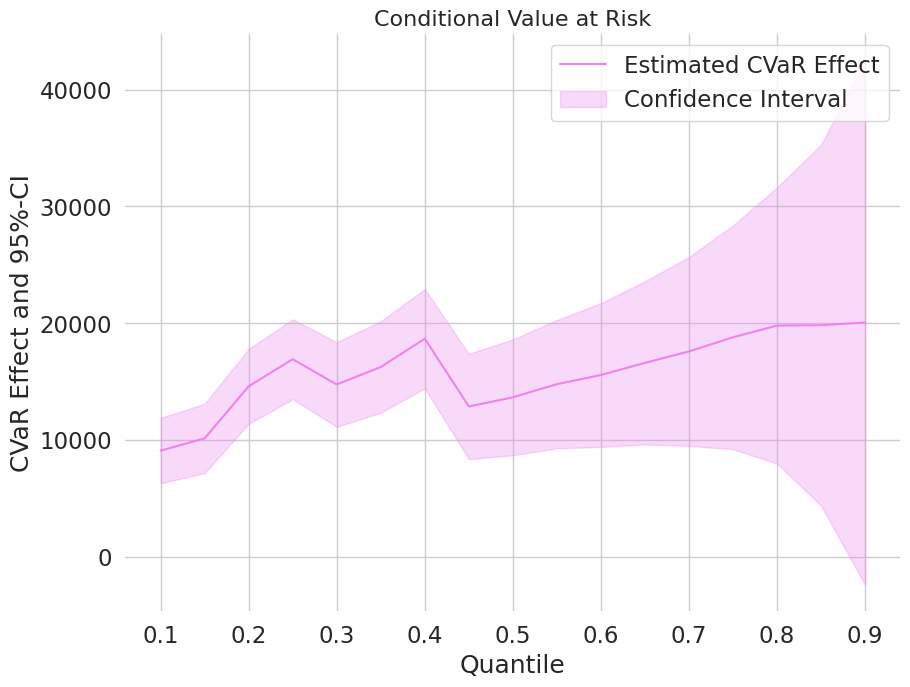

In [17]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid(visible=True)

ax.plot(df_cvar['Quantile'],df_cvar['DML CVAR'], color='violet', label='Estimated CVaR Effect')
ax.fill_between(df_cvar['Quantile'], df_cvar['DML CVAR lower'], df_cvar['DML CVAR upper'], color='violet', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Conditional Value at Risk', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('CVaR Effect and 95%-CI')

## Estimating local quantile treatment effects (LQTEs)

If we have an `IIVM` model with a given instrumental variable, we are still able to identify the local quantile treatment effect (LQTE), the quantile treatment effect on compliers. For the 401(k) pension data we can use `e401` as an instrument for participation `p401`. 
To fit an `DoubleML` model with an instrument, we have to change the data backend and specify the instrument.

In [18]:
# Initialize DoubleMLData with an instrument

# Basic model
data_dml_base_iv = dml.DoubleMLData(data,
                                    y_col='net_tfa',
                                    d_cols='p401',
                                    z_cols='e401',
                                    x_cols=features_base)

print(data_dml_base_iv)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['p401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): ['e401']
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float32(4), int8(10)
memory usage: 251.9 KB



The estimation of local treatment effects can be easily done by adjusting the score in the `DoubleMLQTE` object to `score="LPQ"`.

In [19]:
np.random.seed(42)
dml_LQTE = dml.DoubleMLQTE(data_dml_base_iv,
                           ml_g=clone(class_learner),
                           ml_m=clone(class_learner),
                           quantiles=tau_vec,
                           score="LPQ",
                           n_folds=n_folds,
                           normalize_ipw=True,
                           trimming_rule="truncate",
                           trimming_threshold=1e-2)
dml_LQTE.fit(n_jobs_models=cores_used)
print(dml_LQTE)

================== DoubleMLQTE Object ==================

------------------ Fit summary       ------------------
         coef      std err          t         P>|t|         2.5 %   
0.10   2610.0   487.701966   5.351629  8.716595e-08   1654.121711  \
0.15   1773.0   357.148790   4.964318  6.894307e-07   1073.001234   
0.20   1398.0   386.526532   3.616828  2.982353e-04    640.421919   
0.25   1435.0   384.956574   3.727693  1.932404e-04    680.498979   
0.30   1400.0   436.977295   3.203828  1.356136e-03    543.540240   
0.35   2500.0   486.877153   5.134765  2.824961e-07   1545.738315   
0.40   3985.0   596.725087   6.678117  2.420316e-11   2815.440320   
0.45   5175.0   739.897240   6.994214  2.667492e-12   3724.828058   
0.50   7239.0   775.751013   9.331602  1.042822e-20   5718.555954   
0.55   9500.0  1109.023955   8.566091  1.070574e-17   7326.352990   
0.60  11750.0  1295.711518   9.068377  1.208034e-19   9210.452091   
0.65  14625.0  1443.080854  10.134567  3.880880e-24  11796

Estimation of the corresponding (uniformly) valid confidence intervals can be done analogously to the quantile treatment effects.

In [20]:
dml_LQTE.bootstrap(n_rep_boot=2000)
ci_LQTE = dml_LQTE.confint(level=0.95, joint=True)

data_lqte = {"Quantile": tau_vec, "DML LQTE": dml_LQTE.coef,
            "DML LQTE lower": ci_LQTE["2.5 %"], "DML LQTE upper": ci_LQTE["97.5 %"]}
df_lqte = pd.DataFrame(data_lqte)
print(df_lqte)

      Quantile  DML LQTE  DML LQTE lower  DML LQTE upper
0.10      0.10    2610.0     1255.761419     3964.238581
0.15      0.15    1773.0      781.278202     2764.721798
0.20      0.20    1398.0      324.702827     2471.297173
0.25      0.25    1435.0      366.062246     2503.937754
0.30      0.30    1400.0      186.612415     2613.387585
0.35      0.35    2500.0     1148.051740     3851.948260
0.40      0.40    3985.0     2328.028753     5641.971247
0.45      0.45    5175.0     3120.471914     7229.528086
0.50      0.50    7239.0     5084.914056     9393.085944
0.55      0.55    9500.0     6420.490114    12579.509886
0.60      0.60   11750.0     8152.100775    15347.899225
0.65      0.65   14625.0    10617.889300    18632.110700
0.70      0.70   16984.0    12606.235049    21361.764951
0.75      0.75   19758.0    11801.354953    27714.645047
0.80      0.80   24005.0    17623.500342    30386.499658
0.85      0.85   27751.0    18999.239329    36502.760671
0.90      0.90   30645.0    177

Finally, let us take a look at the estimated local quantile treatment effects.

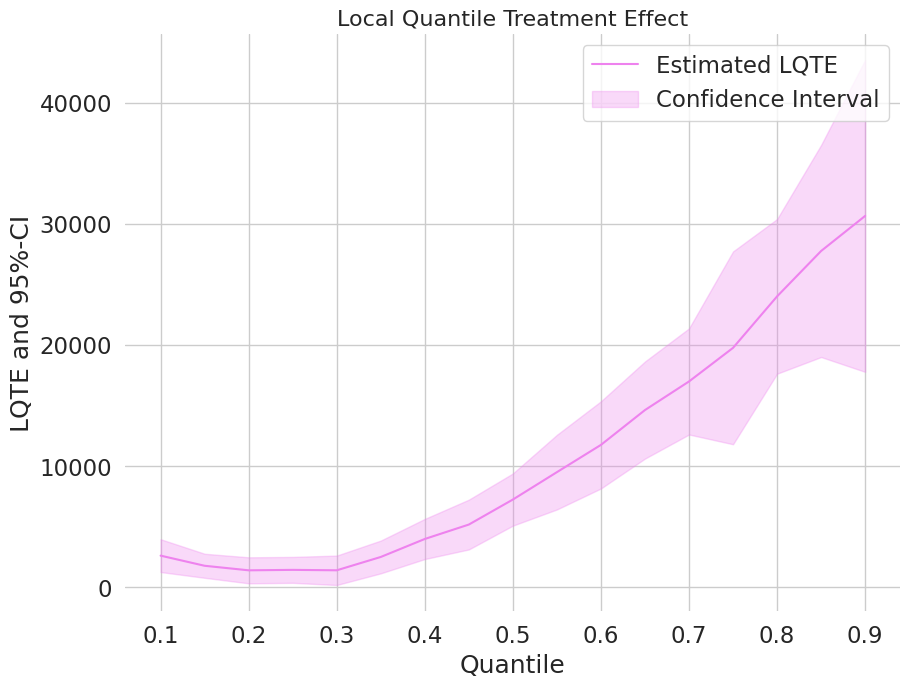

In [21]:
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()
ax.grid(visible=True)

ax.plot(df_lqte['Quantile'],df_lqte['DML LQTE'], color='violet', label='Estimated LQTE')
ax.fill_between(df_lqte['Quantile'], df_lqte['DML LQTE lower'], df_lqte['DML LQTE upper'], color='violet', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Local Quantile Treatment Effect', fontsize=16)
plt.xlabel('Quantile')
_ = plt.ylabel('LQTE and 95%-CI')